In [24]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [43]:
from utils import load_splits

In [26]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Numbering of sections correspond to the sequence of the large text headers in original yyy notebook.

# 2 | Prevalence of communication failures by age 

Requires Levenhstein distances from "Levenshtein distance in Providence.ipynb", saved under 'csv/pvd_levdist.csv'.

In [28]:
from yyy_analysis import get_communication_analysis_data

In [29]:
chi_phono = get_communication_analysis_data.get_communication_failures_data()

R[write to console]: Using current database version: '2020.1'.

R[write to console]: Using supported database version: '2020.1'.



In [30]:
error_codes = ('yyy')

In [31]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [32]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

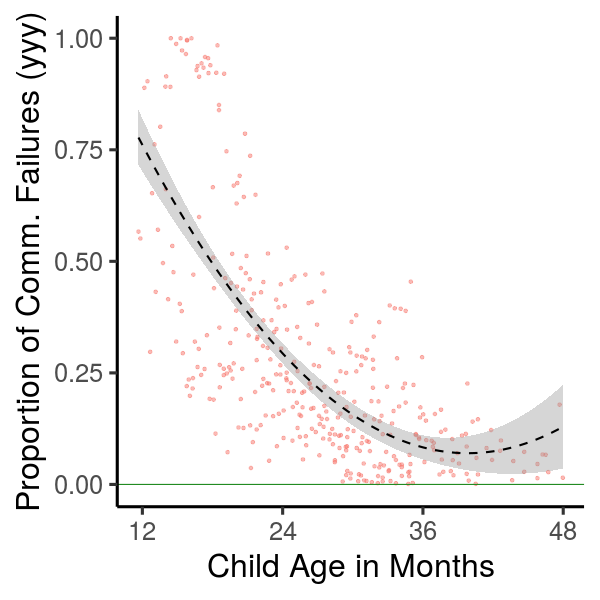

In [33]:
%%R -w 600 -h 600

pvd_comm_error = subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')

pvd_comm_error$age_in_months = pvd_comm_error$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

ggplot(pvd_comm_error) + geom_point(aes(x=target_child_age_months, 
y=proportion_errors, color= "collection_name"), alpha=.5) + theme_classic(base_size =32) + xlab('Child Age in Months') + ylab(
'Proportion of Comm. Failures (yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors),  linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black')  + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months) + geom_hline(yintercept=0,
    color = "forestgreen") +theme(legend.position="none")

## Require the pvd_levdist.csv generation code to refactor properly -- it's not in the latest Levenshtein distance code

In [34]:
%%R
# Data for Lvenshtin distances in Providence comes from notebook "Levenshtein distance in Providence"
chi_levdist = read.csv('csv/pvd_levdist.csv')

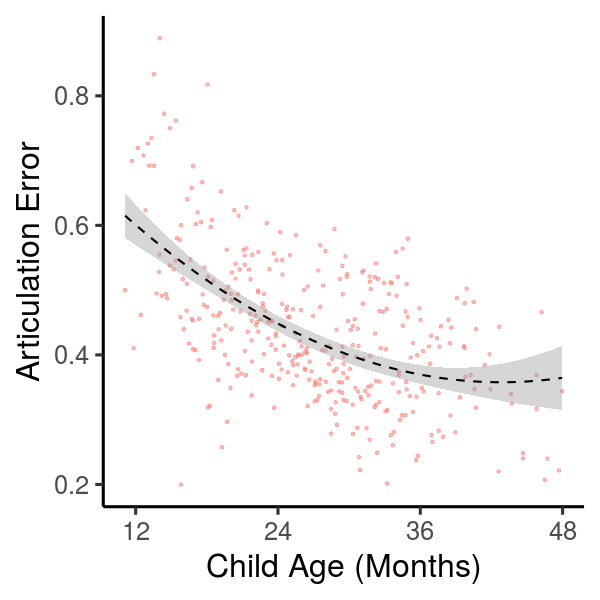

In [35]:
%%R -h 600 -w 600
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

p1 = ggplot(subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence')) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + theme_classic(base_size = 32) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Articulation Error"
) + xlab('Child Age (Months)') + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
print(p1)

In [39]:
%%R
chi_levdist$age_in_months = NULL
pvd_comm_error_merged = merge(pvd_comm_error, chi_levdist,
        by=c('transcript_id'))
nrow(pvd_comm_error_merged)

[1] 359


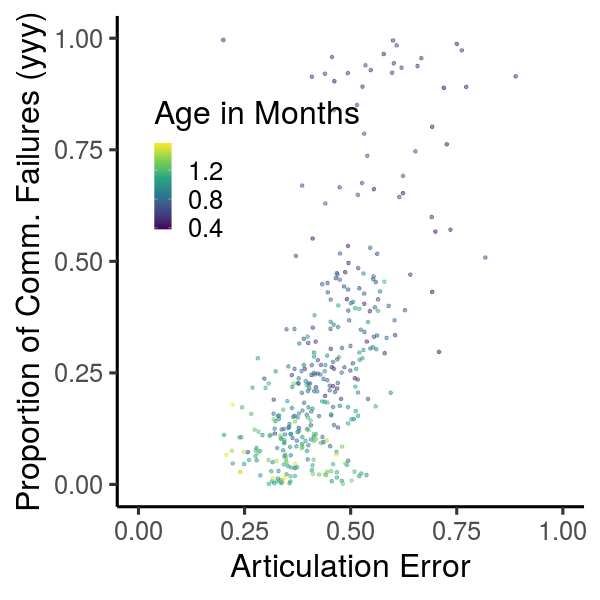

In [40]:
%%R -w 600 -h 600
names(pvd_comm_error_merged)

p1 = ggplot(pvd_comm_error_merged) + geom_point(aes(x=mean_levdist, y=proportion_errors, 
color=age_in_months), alpha=.5)  + theme_classic(base_size = 32
)  + coord_cartesian(ylim=c(0,1), xlim =c(0,1)) + scale_color_viridis_c(
) + ylab('Proportion of Comm. Failures (yyy)') + xlab('Articulation Error'
) + theme(legend.position=c(.3, .7), legend.background=element_blank()) + labs(color = "Age in Months") 

print(p1)


In [41]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

,transcript_id,proportion_errors,target_child_age_months,num_tokens,corpus_name
1,42205,0.957921,17.358607,404.0,Providence
3,42207,0.984102,18.422131,629.0,Providence
105,42309,0.987261,14.889344,628.0,Providence
106,42310,0.964646,15.723361,594.0,Providence
107,42311,0.972692,15.395492,769.0,Providence
108,42312,0.995117,15.821721,1024.0,Providence
270,42474,1.000000,14.430328,171.0,Providence
271,42475,1.000000,15.264344,265.0,Providence
272,42476,0.996212,15.821721,264.0,Providence
273,42477,1.000000,16.196721,68.0,Providence


In [ ]:
# Manually confirm that these transcripts indeed have a very high proportion of errors
# Was not yet done for the refactor, but refactor code is basically same for this section as the original.

# 6  | Prevalence of Successes and Failures Across Time

In [47]:
utt_age = chi_phono.groupby('utterance_id').target_child_age.agg(np.unique).reset_index()


all_eval_data = load_splits.load_eval_data_all('all', 'all')

success_utts = all_eval_data['success_utts']
yyy_utts = all_eval_data['yyy_utts']

utts_with_ages = pd.concat([success_utts, yyy_utts]).merge(utt_age)
%R -i utts_with_ages


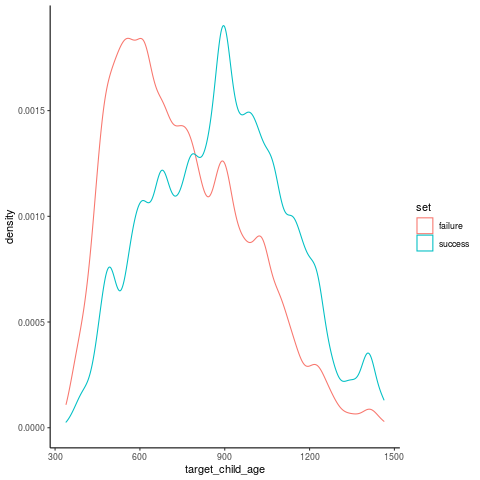

In [48]:
%%R
### Number of utterances by Age
ggplot(utts_with_ages) + geom_density(aes(x=target_child_age, color=set)) + theme_classic()


In [49]:
utts_with_ages = data_cleaning.get_target_child_year(utts_with_ages)
print(utts_with_ages.loc[utts_with_ages.set == 'failure'].year.value_counts())
print(utts_with_ages.loc[utts_with_ages.set == 'success'].year.value_counts())

1.5    9919
2.0    7261
1.0    6693
2.5    4895
3.0    2097
3.5     414
0.5     167
4.0      11
Name: year, dtype: int64
2.0    22432
2.5    21194
1.5    16798
3.0    12564
1.0     6697
3.5     3683
4.0      379
0.5      133
Name: year, dtype: int64
